In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle

## load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)
    
#with open('data/continent_to_reviews.pkl', 'rb') as f:
#    continent_to_reviews = pickle.load(f)


In [2]:
# Find the top 10 influential airports
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top10 = sorted_degree_centrality[:10]



# Get their latitude and longitude
lat = []
lon = []
for airport in top10:
    lat.append(G.nodes[airport[0]]['latitude'])
    lon.append(G.nodes[airport[0]]['longitude'])

#combine the latitude and longitude in one list so i have a list in the form [(lat1, lon1), (lat2, lon2), ...], and save the labels
top10_labels = [airport[0] for airport in top10]
lat_lon = list(zip(lat, lon))
print(top10_labels)
print(lat_lon)


['FRA', 'CDG', 'AMS', 'IST', 'ATL', 'ORD', 'PEK', 'MUC', 'DME', 'DFW']
[(50.033333, 8.570556), (49.012798, 2.55), (52.308601, 4.76389), (41.275278, 28.751944), (33.6367, -84.428101), (41.9786, -87.9048), (40.0801010131836, 116.58499908447266), (48.353802, 11.7861), (55.40879821777344, 37.90629959106445), (32.896801, -97.038002)]


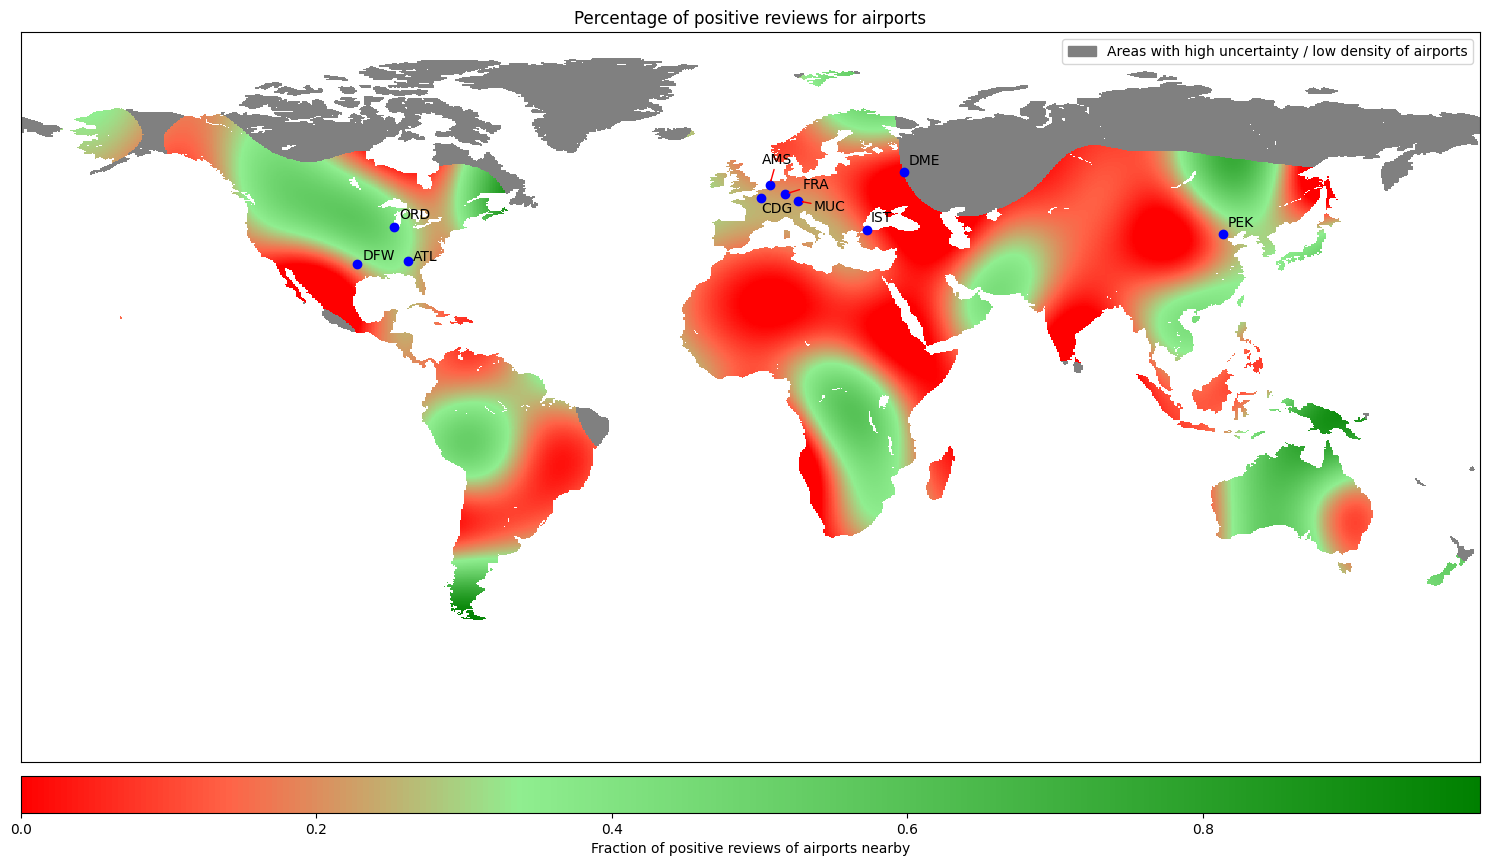

In [8]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from adjustText import adjust_text


## make a grey cmap, that always returns grey
cmap_grey = LinearSegmentedColormap.from_list(
    "grey", 
    [(0, "grey"), (1, "grey")]
)

airports = pd.read_csv("data/airports_cleaned.csv", index_col=0)
airports = airports.dropna(subset=["average_recommendation"])
X = airports[["latitude", "longitude"]].to_numpy()
y = airports["average_recommendation"].to_numpy()

kernel = RBF(length_scale=15, length_scale_bounds="fixed")
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)
model.fit(X, y)

resolution = 1000
lats, lons = X[:, 0], X[:, 1]
min_lats, max_lats = -90, 90
min_lons, max_lons = -180, 180

lats = np.linspace(min_lats, max_lats, resolution)
lons = np.linspace(min_lons, max_lons, resolution)
lats, lons = np.meshgrid(lats, lons)
Xmesh = np.vstack([lats.ravel(), lons.ravel()]).T
ymesh, uncertainty = model.predict(Xmesh, return_std=True)
uncertainty = uncertainty.reshape((resolution, resolution))
ymesh = ymesh.reshape((resolution, resolution))
ymesh = np.clip(ymesh, 0, 1)

## get 25th and 75th percentile
percentilelow = np.percentile(ymesh.flatten(), 25)
percentilehigh = np.percentile(ymesh.flatten(), 80)

## make a colormap that is red for low values and green for high values of ymesh
cmap = LinearSegmentedColormap.from_list(
    "custom", 
    [(0, "red"), (percentilelow, "tomato"), (percentilehigh, "lightgreen"), (1, "green")]
) 

def is_water(lat, lon):
    return not m.is_land(lon, lat)

try: 
    ywater = np.load(f"data/ywater{resolution}.npy")
except:
    ywater = np.zeros_like(ymesh)
    for i in tqdm(range(ymesh.shape[0])):
        for j in range(ymesh.shape[1]):
            if is_water(lats[i, j], lons[i, j]):
                ywater[i, j] = 1
    np.save(f"data/ywater{resolution}.npy", ywater)
            
watermasked = np.ma.masked_where(ywater == 1, ymesh)
max_uncertainty = 0.15
uncertain_or_water_masked = np.ma.masked_where((uncertainty < max_uncertainty) | (ywater == 1), np.ones_like(ymesh))

fig, ax = plt.subplots(figsize=(15, 10))
m = Basemap(lon_0=0)
m.pcolormesh(lons, lats, watermasked, cmap=cmap, shading='auto')
m.colorbar(location="bottom", label="Fraction of positive reviews of airports nearby")
m.pcolor(lons, lats, uncertain_or_water_masked, cmap=cmap_grey)
## make a legend for the uncertainty
grey_patch = mpatches.Patch(color='grey', label='Areas with high uncertainty / low density of airports')

#add the top 10 airports to the map as blue dots
for i, (lat, lon) in enumerate(lat_lon):
    x, y = m(lon, lat)
    m.scatter(x, y, color="blue", label=f"Top {i+1} airport")

#add the labels to the top 10 airports
texts = []
for i, (lat, lon) in enumerate(lat_lon):
    x, y = m(lon, lat)
    texts.append(plt.text(x, y, top10_labels[i], fontsize=10))

# Use adjust_text to automatically adjust the labels
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
#ensure that the labels dont overlap
plt.tight_layout()



plt.legend(handles=[grey_patch])
plt.title("Percentage of positive reviews for airports")
plt.savefig('images/average_recommendation.png', dpi=300, bbox_inches='tight')

[['FRA', 0.22576307440297058, 0.14654377880184333], ['CDG', 0.2257630697650142, 0.1443932411674347], ['AMS', 0.22576307243465385, 0.14224270353302612], ['IST', 0.22576309053993301, 0.13978494623655913], ['ATL', 0.3341890758842325, 0.13302611367127495], ['ORD', 0.34354557907382355, 0.12565284178187405], ['PEK', 0.22576494090849372, 0.12534562211981568], ['MUC', 0.22576307575998195, 0.11674347158218126], ['DME', 0.2257631433618515, 0.11551459293394778], ['DFW', 0.33265246504930246, 0.11428571428571428], ['DXB', 0.22576312119895556, 0.1130568356374808], ['LHR', 0.22576306944927185, 0.10506912442396313], ['IAH', 0.32797616543858465, 0.10353302611367128], ['DEN', 0.3396655047416729, 0.10291858678955453], ['LGW', 0.22576306944927185, 0.10138248847926268], ['BCN', 0.2257630669259344, 0.10015360983102918], ['JFK', 0.3395631549016699, 0.0989247311827957], ['FCO', 0.2257630725106967, 0.09708141321044547], ['MAD', 0.2843999984657881, 0.09646697388632873], ['STN', 0.22576306944927185, 0.0937019969

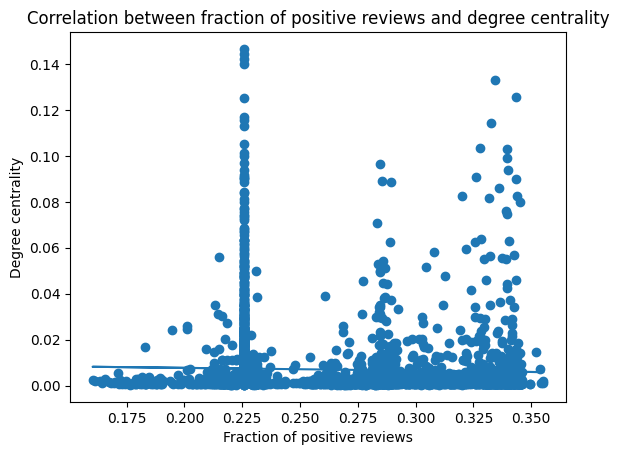

In [76]:
#giv me the value of "Fraction of positive reviews of airports nearby" for the top 10 airports and print names  of the airports
list_of_airports_fraction = []
for i, (lat, lon) in enumerate(lat_lon):
    x, y = m(lon, lat)
    #list_of_airports_fraction.append(ymesh[int(y), int(x)])
    list_of_airports_fraction.append([top10_labels[i], ymesh[int(y), int(x)]])

for i, airport in enumerate(list_of_airports_fraction):
    airport.append(sorted_degree[i][1])
print(list_of_airports_fraction)

#see if there is a correlation between fraction of positive reviews and degree centrality
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
x = [airport[1] for airport in list_of_airports_fraction]
y = [airport[2] for airport in list_of_airports_fraction]
plt.scatter(x, y)
plt.xlabel("Fraction of positive reviews")
plt.ylabel("Degree centrality")
plt.title("Correlation between fraction of positive reviews and degree centrality")
#plot regression line
m, b = np.polyfit(x, y, 1)
plt.plot(x, [m*x + b for x in x])
print(pearsonr(x, y))
plt.show()
